
Эксперимент: Base, LR=0.001, Batch=16, Optimizer=SGD
Эпоха 0, Тренировочная ошибка: 506.6950, Валидационная ошибка: 441.1532
Эпоха 10, Тренировочная ошибка: 115.3522, Валидационная ошибка: 103.3222
Эпоха 20, Тренировочная ошибка: 90.8032, Валидационная ошибка: 83.2546
Эпоха 30, Тренировочная ошибка: 78.7220, Валидационная ошибка: 74.4605
Эпоха 40, Тренировочная ошибка: 70.2559, Валидационная ошибка: 68.7426
Эпоха 50, Тренировочная ошибка: 64.1991, Валидационная ошибка: 64.7357
Эпоха 60, Тренировочная ошибка: 59.6438, Валидационная ошибка: 61.6281
Эпоха 70, Тренировочная ошибка: 56.2467, Валидационная ошибка: 59.4658
Эпоха 80, Тренировочная ошибка: 53.5782, Валидационная ошибка: 57.6941
Эпоха 90, Тренировочная ошибка: 51.4544, Валидационная ошибка: 56.2929

Эксперимент: Engineered, LR=0.001, Batch=16, Optimizer=SGD
Эпоха 0, Тренировочная ошибка: 369.9647, Валидационная ошибка: 233.6205
Эпоха 10, Тренировочная ошибка: 71.0517, Валидационная ошибка: 63.6844
Эпоха 20, Тренировочная ошибка

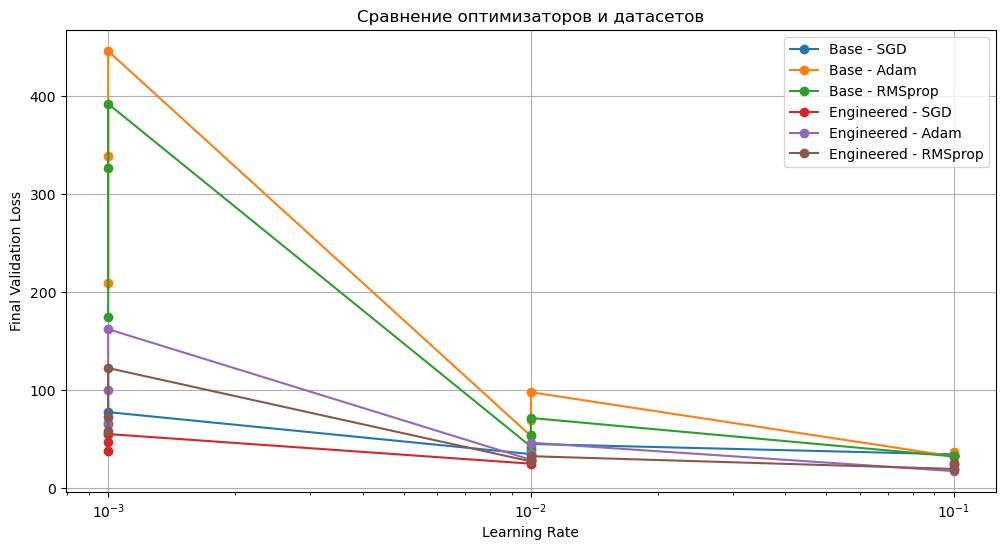

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Dict, List

# Предполагается, что класс CSVDataset уже реализован
# Если его нет, вот минимальная реализация для примера:
class CSVDataset(torch.utils.data.Dataset):
    def __init__(self, csv_file, target_column, column_types=None, scaler_type='minmax', ignore_columns=None):
        self.data = pd.read_csv(csv_file)
        self.target_column = target_column
        self.column_types = column_types or {}
        self.ignore_columns = ignore_columns or []
        self.features = [col for col in self.data.columns if col != target_column and col not in self.ignore_columns]
        
        if scaler_type == 'minmax':
            self.scaler = MinMaxScaler()
            self.data[self.features] = self.scaler.fit_transform(self.data[self.features])
        
        self.X = torch.tensor(self.data[self.features].values, dtype=torch.float32)
        self.y = torch.tensor(self.data[target_column].values, dtype=torch.float32).reshape(-1, 1)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
    def get_num_features(self):
        return len(self.features)
    
    def get_feature_names(self):
        return self.features

# Модель линейной регрессии
class LinearRegression(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.linear = nn.Linear(in_features, 1)
    
    def forward(self, x):
        return self.linear(x)

# Функция для обучения модели
def train_model(model, criterion, optimizer, train_dataloader, val_dataloader, epochs, num_classes, task='regression'):
    train_losses, val_losses = [], []
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_dataloader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * X_batch.size(0)
        train_loss /= len(train_dataloader.dataset)
        train_losses.append(train_loss)
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_dataloader:
                y_pred = model(X_batch)
                loss = criterion(y_pred, y_batch)
                val_loss += loss.item() * X_batch.size(0)
            val_loss /= len(val_dataloader.dataset)
            val_losses.append(val_loss)
        
        if epoch % 10 == 0:
            print(f"Эпоха {epoch}, Тренировочная ошибка: {train_loss:.4f}, Валидационная ошибка: {val_loss:.4f}")
    
    return model, train_losses, val_losses

# Функция для создания новых признаков
def create_engineered_features(data: pd.DataFrame, features: List[str]) -> pd.DataFrame:
    # Полиномиальные признаки (степень 2)
    poly = PolynomialFeatures(degree=2, include_bias=False)
    poly_features = poly.fit_transform(data[features])
    poly_feature_names = poly.get_feature_names_out(features)
    poly_df = pd.DataFrame(poly_features, columns=poly_feature_names, index=data.index)
    
    # Статистические признаки
    data['mean_features'] = data[features].mean(axis=1)
    data['var_features'] = data[features].var(axis=1)
    
    # Объединяем новые признаки с исходными
    engineered_data = pd.concat([data, poly_df], axis=1)
    
    return engineered_data

# Основной эксперимент
def run_experiments():
    # Параметры для экспериментов
    learning_rates = [0.001, 0.01, 0.1]
    batch_sizes = [16, 32, 64]
    optimizers = {
        'SGD': lambda params, lr: optim.SGD(params, lr=lr, weight_decay=0.01),
        'Adam': lambda params, lr: optim.Adam(params, lr=lr),
        'RMSprop': lambda params, lr: optim.RMSprop(params, lr=lr)
    }
    
    results = []
    
    # Загрузка базового датасета
    dataset = CSVDataset(
        csv_file='https://raw.githubusercontent.com/selva86/datasets/master/BostonHousing.csv',
        target_column='medv',
        column_types={'chas': 'binary'},
        scaler_type='minmax',
        ignore_columns=[]
    )
    
    # Создание датасета с новыми признаками
    data = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/BostonHousing.csv')
    features = [col for col in data.columns if col != 'medv']
    engineered_data = create_engineered_features(data, features)
    engineered_data.to_csv('engineered_boston_housing.csv', index=False)
    
    engineered_dataset = CSVDataset(
        csv_file='engineered_boston_housing.csv',
        target_column='medv',
        column_types={'chas': 'binary'},
        scaler_type='minmax',
        ignore_columns=[]
    )
    
    # Разделение данных
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
    train_dataset_engineered, val_dataset_engineered = torch.utils.data.random_split(engineered_dataset, [train_size, val_size])
    
    # Эксперименты
    for lr in learning_rates:
        for batch_size in batch_sizes:
            for opt_name, opt_func in optimizers.items():
                for dataset_type, current_dataset in [('Base', dataset), ('Engineered', engineered_dataset)]:
                    train_dataloader = DataLoader(train_dataset if dataset_type == 'Base' else train_dataset_engineered, 
                                               batch_size=batch_size, shuffle=True)
                    val_dataloader = DataLoader(val_dataset if dataset_type == 'Base' else val_dataset_engineered, 
                                              batch_size=batch_size)
                    
                    model = LinearRegression(in_features=current_dataset.get_num_features())
                    criterion = nn.MSELoss()
                    optimizer = opt_func(model.parameters(), lr=lr)
                    
                    print(f"\nЭксперимент: {dataset_type}, LR={lr}, Batch={batch_size}, Optimizer={opt_name}")
                    model, train_losses, val_losses = train_model(
                        model, criterion, optimizer, train_dataloader, val_dataloader, 
                        epochs=100, num_classes=1, task='regression'
                    )
                    
                    results.append({
                        'Dataset': dataset_type,
                        'Learning Rate': lr,
                        'Batch Size': batch_size,
                        'Optimizer': opt_name,
                        'Final Val Loss': val_losses[-1]
                    })
    
    # Визуализация результатов
    results_df = pd.DataFrame(results)
    print("\nРезультаты экспериментов:")
    print(results_df.pivot_table(values='Final Val Loss', 
                               index=['Dataset', 'Learning Rate', 'Batch Size'], 
                               columns='Optimizer'))
    
    # Графики
    plt.figure(figsize=(12, 6))
    for dataset_type in ['Base', 'Engineered']:
        for opt_name in optimizers.keys():
            subset = results_df[(results_df['Dataset'] == dataset_type) & (results_df['Optimizer'] == opt_name)]
            plt.plot(subset['Learning Rate'], subset['Final Val Loss'], 
                    label=f'{dataset_type} - {opt_name}', marker='o')
    
    plt.xscale('log')
    plt.xlabel('Learning Rate')
    plt.ylabel('Final Validation Loss')
    plt.title('Сравнение оптимизаторов и датасетов')
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == '__main__':
    run_experiments()